In [1]:
#ANAS
#from google.colab import drive
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional,  Dense, Dropout , BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score


In [2]:
#drive.mount('/content/drive')

In [3]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\WIN-10\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WIN-10\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WIN-10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WIN-10\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
class LSTMCell(Layer):
    def __init__(self, units, **kwargs):
        super(LSTMCell, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.Wx = self.add_weight(shape=(input_dim, self.units * 4),
                                  initializer="glorot_uniform",
                                  name="Wx")
        self.Wh = self.add_weight(shape=(self.units, self.units * 4),
                                  initializer="glorot_uniform",
                                  name="Wh")
        self.bias = self.add_weight(shape=(self.units * 4,),
                                     initializer="zeros",
                                     name="bias")
        self.built = True

    def call(self, inputs, states):
        h_tm1, c_tm1 = states
        z = tf.matmul(inputs, self.Wx) + tf.matmul(h_tm1, self.Wh) + self.bias
        z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=1)
        i = tf.sigmoid(z0)
        f = tf.sigmoid(z1)
        o = tf.sigmoid(z3)
        g = tf.tanh(z2)
        c_t = f * c_tm1 + i * g
        h_t = o * tf.tanh(c_t)
        return h_t, [h_t, c_t]

    def get_config(self):
        config = super(LSTMCell, self).get_config()
        config.update({"units": self.units})
        return config


In [5]:
class LSTM(Layer):
    def __init__(self, units, return_sequences=False, **kwargs):
        super(LSTM, self).__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.cell = LSTMCell(units)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]
        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))

        def step_fn(prev_states, x_t):
            h, c = prev_states
            h, [h, c] = self.cell(x_t, [h, c])
            return h, c

        h_states = tf.TensorArray(tf.float32, size=time_steps)

        for t in tf.range(time_steps):
            h, c = step_fn([h, c], inputs[:, t, :])
            h_states = h_states.write(t, h)

        if self.return_sequences:
            return tf.transpose(h_states.stack(), [1, 0, 2])
        else:
            return h

    def get_config(self):
        config = super(LSTM, self).get_config()
        config.update({
            "units": self.units,
            "return_sequences": self.return_sequences
        })
        return config


In [6]:
df = pd.read_csv("train.csv")
df = df.iloc[:, 1:]

wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r'http\S+|www\S+|@\S+|#\S+', '', text)
    text = "".join([char for char in text if char.isalpha() or char.isspace()])


    tokens = word_tokenize(text.lower())

    tokens = [word for word in tokens if word not in stop_words]

    tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

df['Discussion'] = df['Discussion'].apply(preprocess_text)
df = df.dropna()

In [7]:
print(df['Category'])
category_mapping = {'Politics': 0, 'Sports': 1, 'Media': 2, 'Market & Economy': 3, 'STEM': 4}
df['Category'] = df['Category'].map(category_mapping)
print(df['Category'])

0                  Sports
1                    STEM
2                    STEM
3                  Sports
4                Politics
               ...       
24984              Sports
24985    Market & Economy
24986    Market & Economy
24987            Politics
24988               Media
Name: Category, Length: 24989, dtype: object
0        1
1        4
2        4
3        1
4        0
        ..
24984    1
24985    3
24986    3
24987    0
24988    2
Name: Category, Length: 24989, dtype: int64


In [8]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['Discussion']).toarray()

y = np.array(df['Category'])
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)
y = to_categorical(y)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape[0])
print(X_train.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

19991
5000


In [10]:
# model_lstm = tf.keras.Sequential([
from tensorflow.keras import regularizers
#     # LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
#     # tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Dropout(0.3),
#     LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.3),
#     LSTM(64, return_sequences=False),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
# ])
model_lstm = Sequential([
    # First LSTM layer with Dropout and BatchNormalization
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.4),  # Increased dropout to reduce overfitting

    # Second LSTM layer
    LSTM(64, return_sequences=False),
    Dropout(0.3),  # Adjusted dropout here

    # Dense layer with L2 Regularization
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),

    # Output layer with softmax activation
    Dense(y_train.shape[1], activation='softmax')
])

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_lstm.fit(X_train, y_train, epochs=30, batch_size=64,
                         validation_data=(X_test, y_test),
                         callbacks=[early_stopping])
print("aaa")
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test, verbose=2)
print(f'Bidirectional LSTM Test Accuracy: {test_accuracy * 100:.2f}%')

model_lstm.save('tfidf_lstm_model.h5')

Epoch 1/30
313/313 [==============================] - 7s 15ms/step - loss: 1.2982 - accuracy: 0.5615 - val_loss: 1.2868 - val_accuracy: 0.5712
Epoch 2/30
313/313 [==============================] - 4s 13ms/step - loss: 0.8227 - accuracy: 0.7103 - val_loss: 0.9090 - val_accuracy: 0.6531
Epoch 3/30
313/313 [==============================] - 4s 11ms/step - loss: 0.7156 - accuracy: 0.7487 - val_loss: 0.9191 - val_accuracy: 0.6573
Epoch 4/30
313/313 [==============================] - 4s 12ms/step - loss: 0.6567 - accuracy: 0.7670 - val_loss: 0.9800 - val_accuracy: 0.6499
Epoch 5/30
313/313 [==============================] - 4s 12ms/step - loss: 0.6084 - accuracy: 0.7839 - val_loss: 1.0257 - val_accuracy: 0.6449
aaa
157/157 - 1s - loss: 0.9090 - accuracy: 0.6531 - 1s/epoch - 6ms/step
Bidirectional LSTM Test Accuracy: 65.31%


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          1296640   
                                                                 
 batch_normalization (BatchN  (None, None, 64)         256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

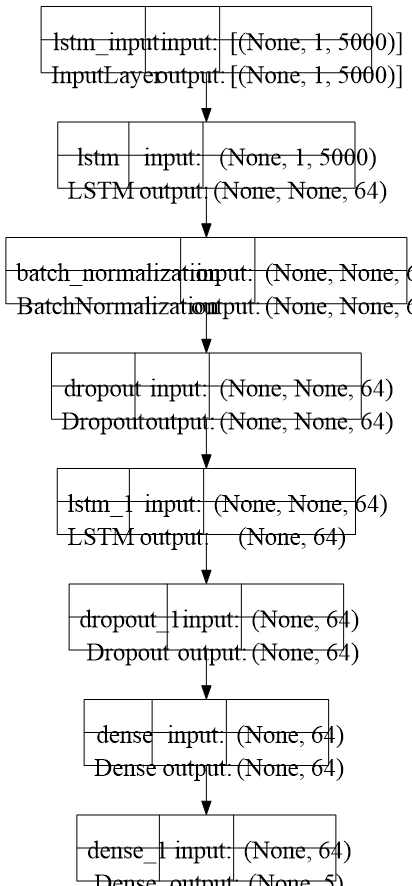

In [15]:
model_lstm.summary()
keras.utils.plot_model(model_lstm, show_shapes=True)

In [13]:
#testing
test_data = pd.read_csv("test.csv")
test_data['Discussion'] = test_data['Discussion'].apply(preprocess_text)
pred = tfidf_vectorizer.transform(test_data['Discussion']).toarray()

pred = pred.reshape(pred.shape[0], 1, pred.shape[1])
pred = model_lstm.predict(pred)
test_predictions = np.argmax(pred, axis=1)
result = pd.DataFrame({
    "SampleID": test_data["SampleID"].values,
    "Category": test_predictions
})
print(result.head(10))
result.to_csv('output.csv', index=False)

330/330 [==============================] - 3s 10ms/step
   SampleID  Category
0         1         3
1         2         0
2         3         1
3         4         4
4         5         3
5         6         0
6         7         3
7         8         3
8         9         4
9        10         3


In [14]:
model = load_model('tfidf_lstm_model.h5')

new_data = pd.read_csv("train.csv")

new_data['Discussion'] = new_data['Discussion'].apply(preprocess_text)
X_new = tfidf_vectorizer.transform(new_data['Discussion']).toarray()

X_new = X_new.reshape(X_new.shape[0], 1, X_new.shape[1])

predictions = model.predict(X_new)
predicted_classes = np.argmax(predictions, axis=1)

new_data['Category'] = new_data['Category'].map(category_mapping)

accuracy = accuracy_score(new_data['Category'], predicted_classes)
print(f"Accuracy on new data: {accuracy * 100:.2f}%")
new_data['Predicted_Class'] = predicted_classes
new_data.to_csv("new_data_with_predictions.csv", index=False)

print("Predictions saved to 'new_data_with_predictions.csv'")

781/781 [==============================] - 7s 8ms/step
Accuracy on new data: 75.11%
Predictions saved to 'new_data_with_predictions.csv'
